# Chating Up - Part 2



In [1]:
import datetime
import numpy as np
import pandas as pd

from collections import Counter
from scipy.stats import chisquare
from scipy.special import factorial

# For pLotting purposes
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from wordcloud import WordCloud
from pandas.plotting import parallel_coordinates

%matplotlib inline

### Data Preparation

Data is loaded. Timestamp string is converted to the python datetime object. Date, time, year, month and year-month columns are created from the datetime column. Further, names from whatsapp and facebook are standardized. Then the users who have deleted their facebook accounts have "Facebook User" against their name in the chats, but the title of the chat page has their name. Such cases are handled. (It doesnt handle the group chats yet.)

A flag is added which marks whether the chat is a group or individual.

In [306]:
# Data Loading
file_path = "data/all_chats.csv"
data = pd.read_csv(file_path)

my_name = "Shivam Rana"

# Filtering out the null text rows
data = data.loc[~data.TEXT.isnull(), :]

# Converion of datetime str to python datetime object
data["DATETIME"] = data["DATETIME"].astype('datetime64[s]')

# Columns from DATETIME field
# data["DATE"] = data.DATETIME.dt.date.astype('datetime64') - wasn't helping with plotting
data["DATE"] = pd.to_datetime(data.DATETIME.dt.date)
data["TIME"] = pd.to_datetime(data.DATETIME.dt.time, format= '%H:%M:%S')
data["YEAR"] = data.DATETIME.dt.year
data["MONTH"] = data.DATETIME.dt.month
data["MONTHYR"] = data.YEAR.astype(str).str.cat(data.MONTH.astype(str).str.zfill(2), sep="-")
data["HOUR"] = data.DATETIME.dt.hour
data["DAY"] = data.DATETIME.dt.weekday_name.str[:3]
data["DATEHRMIN"] = data.DATETIME.dt.strftime("%d%m%Y%H%M")

# Text length
data["TLEN"] = data.TEXT.str.len()

# Standardizing the names.
# You will need to prepare this dict for your puroses
# Key is the "name to standardize" and the value if the "standard name".
frnd_dict = {
}

for frnd in frnd_dict:
    data.loc[data.FROM == frnd, "FROM"] = frnd_dict[frnd]
    data.loc[data.PERSON == frnd, "PERSON"] = frnd_dict[frnd]

# Adding names where we had the string "Facebook User"
for frnd in []:
    data.loc[(data.PERSON==frnd) & (data.FROM == "Facebook User"), "FROM"] = frnd
    
# Adding group flag
groups = data.groupby("PERSON", as_index=False).agg({"FROM": ["nunique", lambda x: 1 if (x == my_name).any() else 0]})

cond1 = (groups["FROM"]["nunique"] > 2) & (groups["FROM"]["<lambda>"] == 1)
cond2 = (groups["FROM"]["nunique"] > 1) & (groups["FROM"]["<lambda>"] == 0)
groups = groups[cond1 | cond2].PERSON.values
data["GRPFLG"] = data.PERSON.apply(lambda x: 1 if x in groups else 0)

cond1 = data.PERSON.astype(str).apply(lambda x: True if " and " in x.lower() else False)
data.loc[cond1, "GRPFLG"] = 1

# Adding time difference between replies
data = data.sort_values(["PERSON", "DATETIME"]).reset_index(drop=True)
data["TDIFF"] = data['DATETIME'].diff() / np.timedelta64(1, 's')
data.loc[(data.PERSON != data.PERSON.shift(1)), 'TDIFF'] = np.nan

# Adding time difference For the user NaN :(
cond = (data.TDIFF.isnull()) & (data.PERSON.isnull())
data.loc[cond, "TDIFF"] = data.loc[cond, "DATETIME"].diff() / np.timedelta64(1, 's')

# New pings per day - threshold of 8 hrs
time_threshold = 8*60*60
cond1 = data.TDIFF > time_threshold
cond2 = data.TDIFF.isnull()
data.loc[:, "STARTS"] = (cond1 | cond2).astype(int)
data.loc[:, "ENDS"] = data.STARTS.shift(-1)
data.loc[data.STARTS == 1, "TDIFF"] = np.nan

# Name masking
data["PERSON_ORIG"] = data.PERSON

# the masking dict.
# key is "name to be masked" and value is the "mask value"
masks = {
}
for mask in masks:
    data.loc[(data.PERSON==mask), "PERSON"] = masks[mask]

data.shape

(299764, 19)

### General Overview

In [307]:
sent_messages = data[data.FROM==my_name]
recv_messages = data[data.FROM!=my_name]
non_group_data = data[data.GRPFLG == 0]
day_chats = data[(data.TIME >= datetime.datetime(1900, 1, 1, 7)) & (data.TIME < datetime.datetime(1900, 1, 1, 19))]
night_chats = data[(data.TIME >= datetime.datetime(1900, 1, 1, 19)) | (data.TIME < datetime.datetime(1900, 1, 1, 7))]

In [308]:
total_days_active = data.DATE.unique().shape[0]
total_days = pd.date_range("2012-01-01", "2018-02-19").shape[0]
print(f"Total days active \t\t: {total_days_active} (out of {total_days})")

print("------------")

total_text = int(data.shape[0])
print(f"Total texts (sent+received) \t: {total_text:,}")

total_out_text = int(sent_messages.shape[0])
print(f"Total sent replies \t\t: {total_out_text:,}")

total_in_text = int(recv_messages.shape[0])
print(f"Total incoming replies \t\t: {total_in_text:,}")

print("------------")
total_convs = data.STARTS.sum()
started_by_me = data[(data.FROM == my_name) & (data.STARTS==1)].STARTS.sum()
print(f"Conversations started by me \t: {started_by_me:,} ({started_by_me*100/total_convs:.2f}%)")

started_by_others = data[(data.FROM != my_name) & (data.STARTS==1)].STARTS.sum()
print(f"Conversations started by others : {started_by_others:,} ({started_by_others*100/total_convs:.2f}%)")

print("------------")

wp_texts = data[data.PLATFORM == "WP"].shape[0]
print(f"Whatsapp \t\t\t: {wp_texts:,} ({wp_texts*100/total_text:.2f}%)")

fb_texts = data[data.PLATFORM == "FB"].shape[0]
print(f"Facebook \t\t\t: {fb_texts:,} ({fb_texts*100/total_text:.2f}%)")

print("------------")

total_chars = int(data.TEXT.str.len().sum())
print(f"Total characters \t\t: {total_chars:,}")

total_sent_chars = int(sent_messages.TEXT.str.len().sum())
print(f"Total sent characters \t\t: {total_sent_chars:,}")

total_recvd_chars = int(recv_messages.TEXT.str.len().sum())
print(f"Total received characters \t: {total_recvd_chars:,}")

print("------------")

total_words = int(len(" ".join(data.TEXT.astype(str)).split()))
print(f"Total words \t\t\t: {total_words:,}")

total_sent_words = int(len(" ".join(sent_messages.TEXT.astype(str)).split()))
print(f"Total sent words \t\t: {total_sent_words:,}")

total_recvd_words = int(len(" ".join(recv_messages.TEXT.astype(str)).split()))
print(f"Total received words \t\t: {total_recvd_words:,}")

print("------------")

# http://commonplacebook.com/art/books/word-count-for-famous-novels/
print(f"Total words in LOTR \t\t: {95022+455125+143436+134462:,}")
print(f"Total words in HP \t\t: {77325+84799+106821+190858+257154+169441+198227:,}")

# https://electricliterature.com/infographic-word-counts-of-famous-books-161f025a6b09
print("Total words in War and Peace\t: 561,304")


Total days active 		: 1935 (out of 2242)
------------
Total texts (sent+received) 	: 299,764
Total sent replies 		: 119,042
Total incoming replies 		: 180,722
------------
Conversations started by me 	: 2,172 (30.19%)
Conversations started by others : 5,022 (69.81%)
------------
Whatsapp 			: 37,219 (12.42%)
Facebook 			: 262,545 (87.58%)
------------
Total characters 		: 9,197,432
Total sent characters 		: 4,370,595
Total received characters 	: 4,826,837
------------
Total words 			: 1,815,134
Total sent words 		: 872,940
Total received words 		: 942,194
------------
Total words in LOTR 		: 828,045
Total words in HP 		: 1,084,625
Total words in War and Peace	: 561,304


In [309]:
minutes = len(data.DATEHRMIN.unique())
print(f"Total time under conversation \t: {minutes:,} mins (or {round(minutes/60):,} hrs, or {round(minutes/(60*24))} days, or {round(minutes/(60*24*30), 1)} months, or {minutes/(60*24*365):.1f} years)")

per_min_sent = sent_messages.shape[0]/minutes
print(f"Replying rate \t\t\t: {round(per_min_sent)} texts per min")

per_min_sent_chars = sent_messages.TLEN.sum()/minutes
print(f"Characters sending rate \t: {per_min_sent_chars:.0f} characters per min")

per_min_recv = recv_messages.shape[0]/minutes
print(f"Replies inbound rate \t\t: {round(per_min_recv)} texts per min")

per_min_recv_chars = recv_messages.TLEN.sum()/minutes
print(f"Characters incoming rate \t: {per_min_recv_chars:.0f} characters per min")


Total time under conversation 	: 102,511 mins (or 1,709 hrs, or 71 days, or 2.4 months, or 0.2 years)
Replying rate 			: 1 texts per min
Characters sending rate 	: 43 characters per min
Replies inbound rate 		: 2 texts per min
Characters incoming rate 	: 47 characters per min


In [311]:
day_chat_count = day_chats.groupby("DATE", as_index=False).TEXT.count().rename(columns={"TEXT": "DAY"})
night_chat_count = night_chats.groupby("DATE", as_index=False).TEXT.count().rename(columns={"TEXT": "NIGHT"})

time_chat_count = day_chat_count.merge(night_chat_count, on="DATE")
time_chat_count["YEAR"] = time_chat_count.DATE.dt.year

print("Day to Night reply count ratio:\n")
time_chat_count.groupby("YEAR").apply(lambda x: (x.DAY.sum()/x.NIGHT.sum()))


Day to Night reply count ratio:



YEAR
2011    0.296296
2012    0.568984
2013    0.345657
2014    0.303708
2015    0.262418
2016    0.223868
2017    0.538305
2018    2.041135
dtype: float64

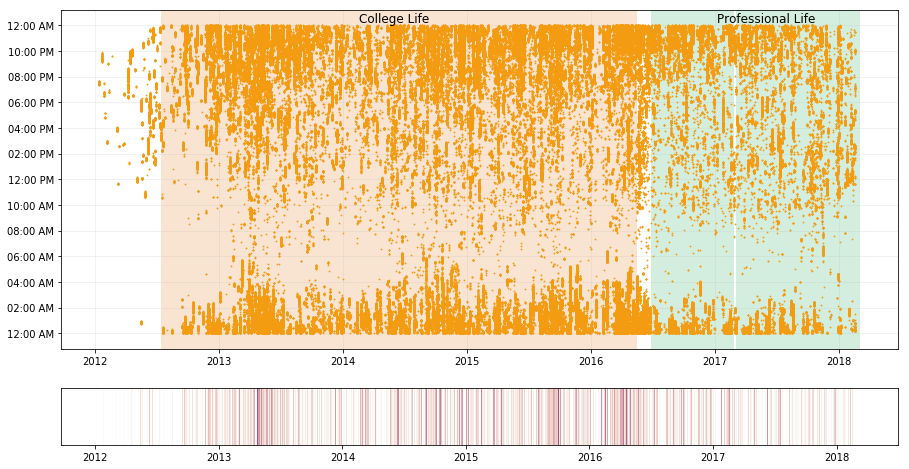

In [294]:
# There are very few texts before 2012 which were distorting the plot.
# So, filtered those rows out.
filter_data = data[data.DATE > '2012-01-01']

# Plotting the scater plot
fig, (ax, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 8), gridspec_kw = {'height_ratios':[6, 1]})
ax.plot_date(
    filter_data.DATE,
    filter_data.TIME,
    ms=0.8,
    color="#f39c12"
)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.yaxis.set_major_formatter(mdates.DateFormatter('%I:%M %p'))

# Formatting the tick labels right
start = datetime.datetime(1900, 1, 1, 0)
time_ticks = [start + datetime.timedelta(hours=i*2) for i in range(13)]
time_ticks = time_ticks[8:] + time_ticks[:8]
time_labels = [i.strftime("%I:%M %p") for i in time_ticks]

ax.set_yticks(time_ticks)
ax.set_yticklabels(time_labels)
ax.grid(b=True, which='major', linestyle='-', alpha=0.2) #color='b', 

# Start and end of College
ax.axvspan("2012-07-15", "2016-05-16", facecolor='#f5cba7', alpha=0.5)
ax.text(
    "2014-06-01", datetime.datetime(1900, 1, 2, 0, 29),
    "College Life",
    ha="center", va="center",
    size=12,
)

# Professional life
ax.axvspan("2016-06-26", "2017-02-28", facecolor='#a9dfbf', alpha=0.5)
ax.axvspan("2017-03-06", "2018-03-06", facecolor='#a9dfbf', alpha=0.5)
ax.text(
    "2017-06-01", datetime.datetime(1900, 1, 2, 0, 29),
    "Professional Life",
    ha="center", va="center",
    size=12,
)

# Plotting the heatmap
all_dates = pd.DataFrame(index=pd.date_range("2011-09-24", "2018-07-01"))
temp = data.groupby("DATE").agg({"TEXT": "count", "TLEN": "count"})
temp = all_dates.join(temp)

# https://stackoverflow.com/a/45349235/2650427
dnum = mdates.date2num(temp.index.to_pydatetime())
start = dnum[0] - (dnum[1]-dnum[0])/2.
stop = dnum[-1] + (dnum[1]-dnum[0])/2.
extent = [start, stop, -0.5, 0.5]

# fig, ax = plt.subplots(figsize=(15, 1))
im = ax2.imshow(
    temp.T,
    aspect="auto",
    extent=extent,
    cmap=sns.cubehelix_palette(light=1, as_cmap=True)
#     cmap=sns.dark_palette("RdBu_r", as_cmap=True, reverse=True)
)
ax2.xaxis.set_major_locator(mdates.YearLocator())
# ax2.xaxis.set_minor_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.set_yticks([])
ax2.set_yticklabels([])
# ax2.set_title("Text count heatmap", loc="left")

_ = fig



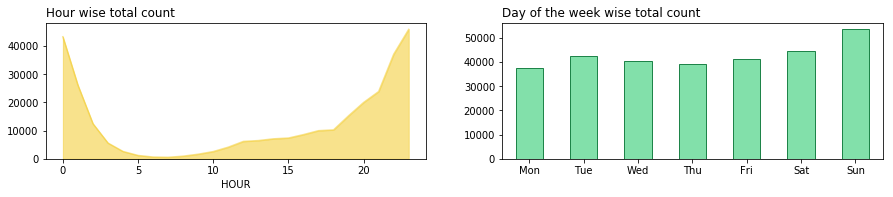

In [211]:
hour_wise = data.groupby("HOUR", as_index=False).agg({"TEXT": "count"}).sort_values(by="HOUR")
hour_wise_sent = sent_messages.groupby("HOUR", as_index=False).agg({"TEXT": "count"}).sort_values(by="HOUR")
hour_wise_recv = recv_messages.groupby("HOUR", as_index=False).agg({"TEXT": "count"}).sort_values(by="HOUR")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 2.5))

hour_wise.plot(x="HOUR", y="TEXT", kind="area", ax=ax1, color="#f4d03f", alpha=0.6)
ax1.legend().set_visible(False)
ax1.set_title("Hour wise total count", loc="left")


day_dict = pd.DataFrame({"ORDER": [1,2,3,4,5,6,7]}, index=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
year_df = data.DAY.value_counts()
year_df = pd.concat([year_df, day_dict], axis=1).sort_values(by="ORDER")
del year_df["ORDER"]

year_df.plot(kind="bar", ax=ax2, color="#82e0aa", edgecolor="#1e8449")
ax2.set_title("Day of the week wise total count", loc="left")
ax2.legend().set_visible(False)
plt.xticks(rotation=0)

_ = fig

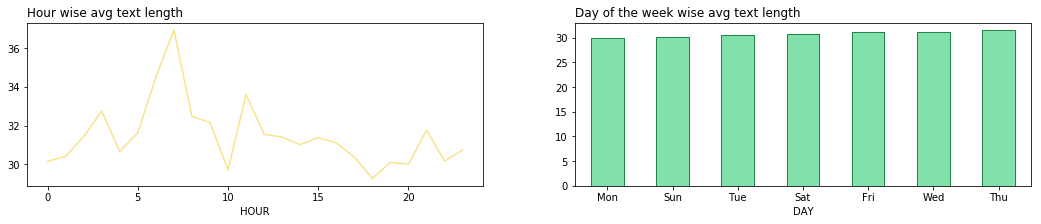

In [687]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 3))

hour_wise = data.groupby("HOUR", as_index=False).agg({"TLEN": "sum", "TEXT": "count"}).sort_values(by="HOUR")
hour_wise["AV"] = hour_wise.TLEN / hour_wise.TEXT
hour_wise.plot(x="HOUR", y="AV", kind="line", ax=ax1, color="#f4d03f", alpha=0.6)
ax1.legend().set_visible(False)
ax1.set_title("Hour wise avg text length", loc="left")

dayweek_wise = data.groupby("DAY", as_index=False).agg({"TLEN": "sum", "TEXT": "count"})
dayweek_wise["AV"] = dayweek_wise.TLEN / dayweek_wise.TEXT
dayweek_wise.sort_values(by="AV").plot(x="DAY", y="AV", kind="bar", ax=ax2, color="#82e0aa", edgecolor="#1e8449")
ax2.set_title("Day of the week wise avg text length", loc="left")
ax2.legend().set_visible(False)
plt.xticks(rotation=0)

_ = ax

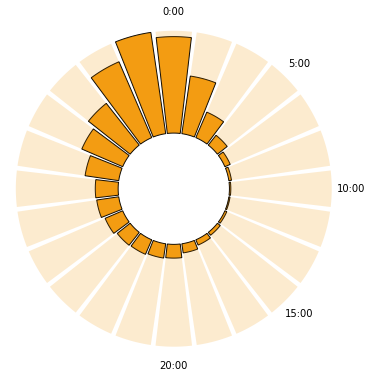

In [6]:
hour_wise = data.groupby("HOUR", as_index=False).agg({"TEXT": "count"}).sort_values(by="HOUR")

N = 24
bottom = 25000
theta, width = np.linspace(0.0, 2 * np.pi, N, endpoint=False, retstep=True)

plt.figure(figsize = (10, 6))
ax = plt.subplot(111, polar=True)
# ax.set_rorigin(-25000)
bars = ax.bar(
    theta, hour_wise.TEXT,
    width=width-0.03,
    bottom=bottom,
    color="#f39c12", edgecolor="black"
)
bars = ax.bar(
    theta, [hour_wise.TEXT.max()]*24,
    width=width-0.03,
    bottom=bottom,
    color="#f39c12", alpha=0.2
)

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.grid(False)
ax.spines['polar'].set_visible(False)
ax.set_rticks([])

# ax.set_rorigin(-2.5)
# ax.set_rmin(25000)

# for t in theta:
#     ax.plot([t, t], [0, -3000], lw=0.82, color="k", alpha=0.6)
#     ax.plot([t, t], [-ax.get_rmax(), ax.get_rmax()*0.9], lw=0.82, color="k", alpha=0.6)
#     ax.text(t, t, "o", color="k")

ticks = [f"{i}:00" for i in range(0, 24, 5)]
ax.set_xticklabels(ticks)


_ = ax

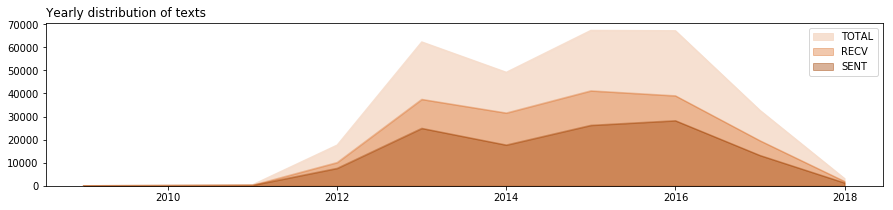

In [209]:
fig, ax = plt.subplots(figsize=(15, 3))

yearly = data.groupby("YEAR").agg({"TEXT": "count"}).rename(columns={"TEXT": "TOTAL"})
yearly = yearly.join(sent_messages.groupby("YEAR").agg({"TEXT": "count"})).rename(columns={"TEXT": "SENT"})
yearly = yearly.join(recv_messages.groupby("YEAR").agg({"TEXT": "count"})).rename(columns={"TEXT": "RECV"})

yearly.plot(y="TOTAL", ax=ax, kind="area", color="#f6ddcc", alpha=0.9)
yearly.plot(y="RECV", ax=ax, kind="area", color="#dc7633", alpha=0.4)
yearly.plot(y="SENT", ax=ax, kind="area", color="#a04000", alpha=0.4)

ax.set_title("Yearly distribution of texts", loc="left")
ax.set_xlabel("")

# ax.set_xticks(range(len(yearly.index.values)))
# ax.set_xticklabels(monthly.index.values)

_ = ax

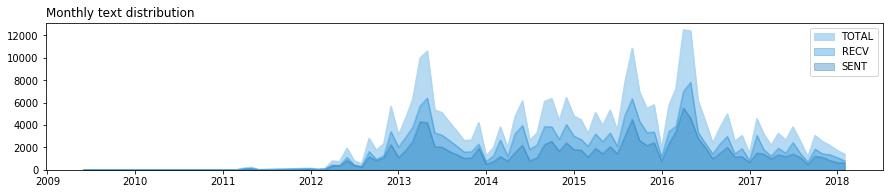

In [208]:
fig, ax = plt.subplots(figsize=(15, 3))

monthly = data.groupby("MONTHYR").agg({"TEXT": "count"}).rename(columns={"TEXT": "TOTAL"})
monthly = monthly.join(sent_messages.groupby("MONTHYR").agg({"TEXT": "count"})).rename(columns={"TEXT": "SENT"})
monthly = monthly.join(recv_messages.groupby("MONTHYR").agg({"TEXT": "count"})).rename(columns={"TEXT": "RECV"})
monthly.index = pd.to_datetime(monthly.index, format="%Y-%m")

monthly.plot(y="TOTAL", ax=ax, kind="area", color="#aed6f1", alpha=0.9)
monthly.plot(y="RECV", ax=ax, kind="area", color="#3498db", alpha=0.4)
monthly.plot(y="SENT", ax=ax, kind="area", color="#2e86c1", alpha=0.4)

ax.set_title("Monthly text distribution", loc="left")
ax.set_xlabel("")
plt.xticks(rotation=0, ha="center")

_ = ax

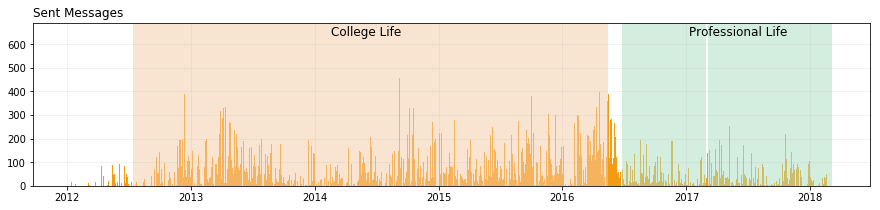

In [207]:
dtfilter = sent_messages.DATE >= "2012-01-01"
bins = sent_messages.DATE.unique().shape[0]

fig, ax = plt.subplots(figsize=(15, 3))
ax.hist(sent_messages[dtfilter].DATETIME.dt.date.values, bins=bins, color="#f39c12")
ax.grid(b=True, which='major', linestyle='-', alpha=0.2)

# Start and end of College
ax.axvspan("2012-07-15", "2016-05-16", facecolor='#f5cba7', alpha=0.5)
ax.text(
    "2014-06-01", 650,
    "College Life",
    ha="center", va="center",
    size=12,
)

# Professional life
ax.axvspan("2016-06-26", "2017-02-28", facecolor='#a9dfbf', alpha=0.5)
ax.axvspan("2017-03-06", "2018-03-06", facecolor='#a9dfbf', alpha=0.5)
ax.text(
    "2017-06-01", 650,
    "Professional Life",
    ha="center", va="center",
    size=12,
)
ax.set_title("Sent Messages", loc="left")
_ = ax

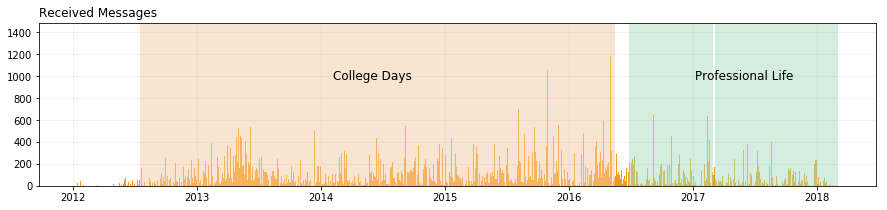

In [206]:
dtfilter = recv_messages.DATE >= "2012-01-01"
bins = recv_messages.DATE.unique().shape[0]

fig, ax = plt.subplots(figsize=(15, 3))
ax.hist(recv_messages[dtfilter].DATETIME.dt.date.values, bins=bins, color="#f39c12")
ax.grid(b=True, which='major', linestyle='-', alpha=0.2)

# Start and end of College
ax.axvspan("2012-07-15", "2016-05-16", facecolor='#f5cba7', alpha=0.5)
ax.text(
    "2014-06-01", 1000,
    "College Days",
    ha="center", va="center",
    size=12,
)

# Professional life
ax.axvspan("2016-06-26", "2017-02-28", facecolor='#a9dfbf', alpha=0.5)
ax.axvspan("2017-03-06", "2018-03-06", facecolor='#a9dfbf', alpha=0.5)
ax.text(
    "2017-06-01", 1000,
    "Professional Life",
    ha="center", va="center",
    size=12,
)
ax.set_title("Received Messages", loc="left")
_ = ax

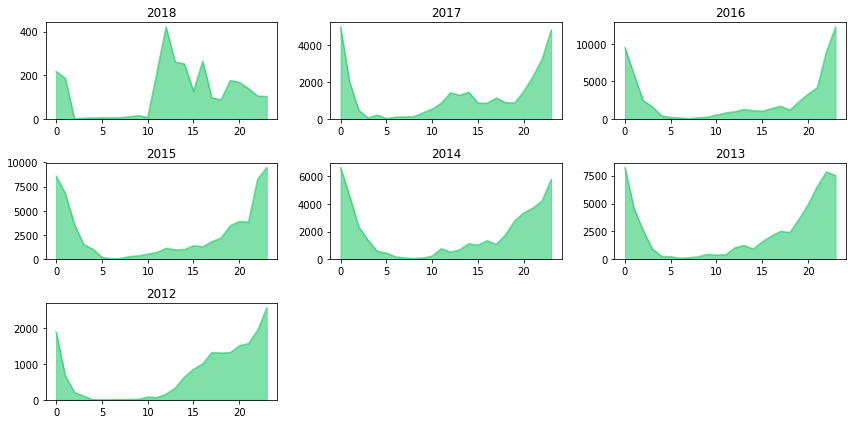

In [204]:
years = sorted(data.YEAR.unique())[::-1][:-2]

nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6), sharex=True, sharey=True)

for i, year in enumerate(years):
    year_df = non_group_data[non_group_data.YEAR == year]
    hour_wise = year_df.groupby("HOUR", as_index=False).agg({"TEXT": "count"}).sort_values(by="HOUR")
    
    ax = plt.subplot(nrows, ncols, i+1)
    hour_wise.plot(x="HOUR", y="TEXT", kind="area", ax=ax, color="#2ecc71", alpha=0.6)
    ax.legend().set_visible(False)
    plt.title(year)
    plt.xlabel("")
    
while i+1 < nrows*ncols:
    fig.delaxes(plt.subplot(nrows, ncols, i+2))
    i += 1

fig.tight_layout()

_ = ax

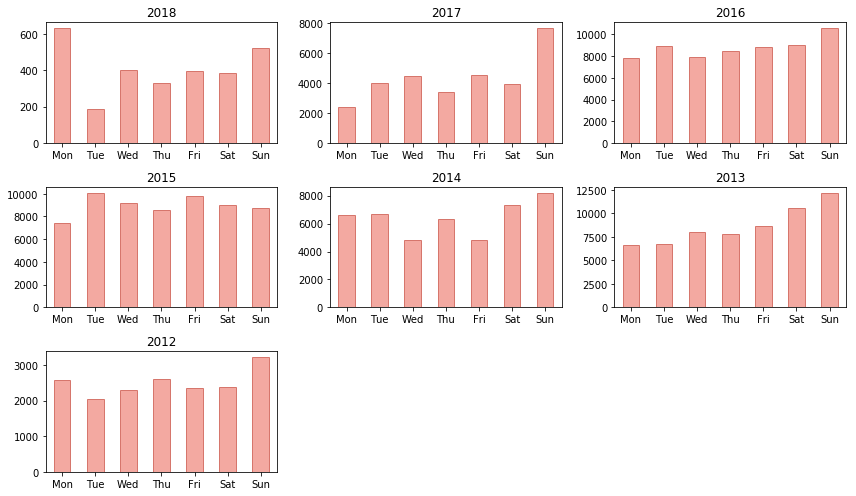

In [203]:
years = sorted(data.YEAR.unique())[::-1][:-2]
day_dict = pd.DataFrame({"ORDER": [1,2,3,4,5,6,7]}, index=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])

nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 7), sharex=True, sharey=True)

for i, year in enumerate(years):
    year_df = non_group_data[non_group_data.YEAR == year]
    year_df = year_df.groupby("DAY").agg({"TEXT": "count"}).join(day_dict).sort_values(by="ORDER")
    del year_df["ORDER"]
    
    ax = plt.subplot(nrows, ncols, i+1)
    year_df.plot(kind="bar", ax=ax, color="#ec7063", edgecolor="#c0392b", alpha=0.6)
    ax.legend().set_visible(False)
    plt.title(year)
    plt.xticks(rotation=0)
    plt.xlabel("")
    
while i+1 < nrows*ncols:
    fig.delaxes(plt.subplot(nrows, ncols, i+2))
    i += 1

# fig.suptitle("Cumulative message count")
fig.tight_layout()

_ = ax

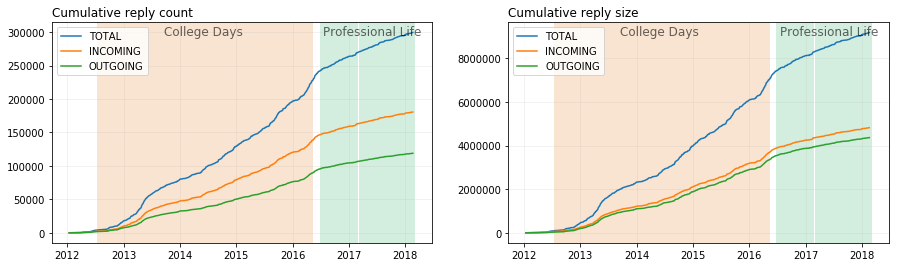

In [202]:
daily_cum = data[data.DATE >= "2012-01-01"].groupby("DATE").agg({"TEXT": "count"}).cumsum(axis=0)
in_daily_cum = recv_messages[recv_messages.DATE >= "2012-01-01"].groupby("DATE").agg({"TEXT": "count"}).cumsum(axis=0)
out_daily_cum = sent_messages[sent_messages.DATE >= "2012-01-01"].groupby("DATE").agg({"TEXT": "count"}).cumsum(axis=0)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 4.5))

daily_cum.plot(ax=ax)
in_daily_cum.plot(ax=ax)
out_daily_cum.plot(ax=ax)
ax.grid(b=True, which='major', linestyle='-', alpha=0.2)
ax.legend(["TOTAL", "INCOMING", "OUTGOING"])
ax.set_xlabel("")

# Start and end of College
ax.axvspan("2012-07-15", "2016-05-16", facecolor='#f5cba7', alpha=0.5)
ax.text(
    "2014-06-01", 300000,
    "College Days",
    ha="center", va="center",
    size=12,
    alpha=0.6
)

# Professional life
ax.axvspan("2016-06-26", "2017-02-28", facecolor='#a9dfbf', alpha=0.5)
ax.axvspan("2017-03-06", "2018-03-06", facecolor='#a9dfbf', alpha=0.5)
ax.text(
    "2017-06-01", 300000,
    "Professional Life",
    ha="center", va="center",
    size=12,
    alpha=0.6
)
ax.set_title("Cumulative reply count", loc="left")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0d'))
plt.xticks(rotation=0, ha="center")
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha="center")


daily_cum = data[data.DATE >= "2012-01-01"].groupby("DATE").agg({"TLEN": "sum"}).cumsum(axis=0)
in_daily_cum = recv_messages[recv_messages.DATE >= "2012-01-01"].groupby("DATE").agg({"TLEN": "sum"}).cumsum(axis=0)
out_daily_cum = sent_messages[sent_messages.DATE >= "2012-01-01"].groupby("DATE").agg({"TLEN": "sum"}).cumsum(axis=0)

daily_cum.plot(ax=ax2)
in_daily_cum.plot(ax=ax2)
out_daily_cum.plot(ax=ax2)
ax2.grid(b=True, which='major', linestyle='-', alpha=0.2)
ax2.legend(["TOTAL", "INCOMING", "OUTGOING"])
ax2.set_xlabel("")

# Start and end of College
ax2.axvspan("2012-07-15", "2016-05-16", facecolor='#f5cba7', alpha=0.5)
ax2.text(
    "2014-06-01", 9200000,
    "College Days",
    ha="center", va="center",
    size=12,
    alpha=0.6
)

# Professional life
ax2.axvspan("2016-06-26", "2017-02-28", facecolor='#a9dfbf', alpha=0.5)
ax2.axvspan("2017-03-06", "2018-03-06", facecolor='#a9dfbf', alpha=0.5)
ax2.text(
    "2017-06-01", 9200000,
    "Professional Life",
    ha="center", va="center",
    size=12,
    alpha=0.6
)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0d'))
ax2.set_title("Cumulative reply size", loc="left")
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0, ha="center")

_ = fig


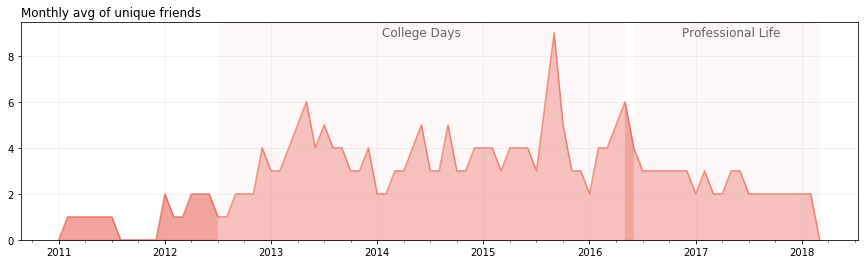

In [213]:
fig, ax = plt.subplots(figsize=(15, 4))

monthyrs = pd.DataFrame(index=np.unique(pd.date_range("2011-01", "2018-03").strftime("%Y-%m")))
monthly = pd.DataFrame(non_group_data[non_group_data.FROM != my_name]\
    .groupby("MONTHYR")\
    .apply(lambda x: round(x.groupby("DATE").PERSON.nunique().sum()/x.DATE.unique().shape[0])))
monthly = monthyrs.join(monthly)
monthly.index = pd.to_datetime(monthly.index, format="%Y-%m")
monthly = monthly.replace(np.nan, 0)

monthly.plot(y=0, kind="area", ax=ax, color="#e74c3c", alpha=0.5)
plt.grid(b=True, which='major', linestyle='-', alpha=0.2)
ax.legend().set_visible(False)
ax.set_title("Monthly avg of unique friends", loc="left")


# Start and end of College
ax.axvspan("2012-07-15", "2016-05-16", facecolor='#fdedec', alpha=0.4)
ax.text(
    "2014-06-01", 9,
    "College Days",
    ha="center", va="center",
    size=12,
    alpha=0.6
)

# Professional life
ax.axvspan("2016-06-26", "2018-03-06", facecolor='#fdedec', alpha=0.4)
ax.text(
    "2017-05-01", 9,
    "Professional Life",
    ha="center", va="center",
    size=12,
    alpha=0.6
)


_ = ax

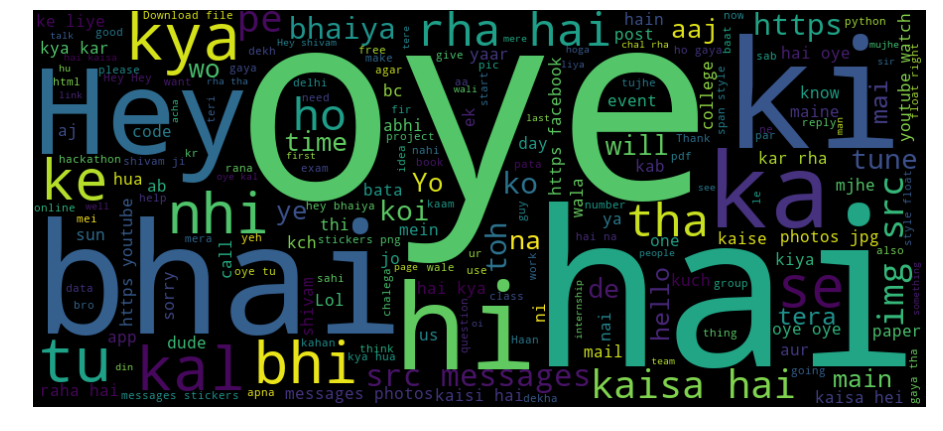

In [464]:
words = " ".join(data[data.STARTS == 1].TEXT)
wordcloud = WordCloud(width=900, height=400).generate(words)

plt.figure(figsize=(16, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
_ = plt

### Top N

In [312]:
# Data Prep
top_n = pd.DataFrame({"PERSON": non_group_data.PERSON.unique()})

# Total unique days
top_n_total_days = non_group_data.groupby("PERSON", as_index=False)\
    .agg({"DATE": "nunique"}).rename(columns={"DATE": "UNIQ_DAYS"})\
    .sort_values(by="UNIQ_DAYS", ascending=False)
top_n = top_n.merge(top_n_total_days, on="PERSON")

# Total text count (mine and friend's)
top_n_total = non_group_data.groupby("PERSON", as_index=False)\
    .agg({"TEXT": "count"}).rename(columns={"TEXT": "TCNT"})\
    .sort_values(by="TCNT", ascending=False)
top_n = top_n.merge(top_n_total, on="PERSON")

# Total text count of friend
top_n_in = non_group_data[non_group_data.FROM != "Shivam Rana"]\
    .groupby("PERSON", as_index=False)\
    .agg({"TEXT": "count"}).rename(columns={"TEXT": "TCNT_FRIEND"})\
    .sort_values(by="TCNT_FRIEND", ascending=False)
top_n = top_n.merge(top_n_in, on="PERSON")

# Total text length (mine and friend's)
top_n_total_len = non_group_data.groupby("PERSON", as_index=False)\
    .agg({"TLEN": pd.np.sum})\
    .sort_values(by="TLEN", ascending=False)
top_n = top_n.merge(top_n_total_len, on="PERSON")

# Total lenght of text of friend's replies
top_n_in_len = non_group_data[non_group_data.FROM != "Shivam Rana"]\
    .groupby("PERSON", as_index=False)\
    .agg({"TLEN": pd.np.sum}).rename(columns={"TLEN": "TLEN_FRIEND"})\
    .sort_values(by="TLEN_FRIEND", ascending=False)
top_n = top_n.merge(top_n_in_len, on="PERSON")

# Mean length of text per reply (averagine over total reply count)
top_n_mean_len = non_group_data.groupby("PERSON", as_index=False)\
    .agg({"TLEN": "mean"}).rename(columns={"TLEN": "MLEN"})\
    .sort_values(by="MLEN", ascending=False)
top_n = top_n.merge(top_n_mean_len, on="PERSON")

# Mean length of text per reply (averaging over friend's reply count)
top_n_in_mean_len = non_group_data[non_group_data.FROM != "Shivam Rana"]\
    .groupby("PERSON", as_index=False)\
    .agg({"TLEN": "mean"}).rename(columns={"TLEN": "MLEN_FRIEND"})\
    .sort_values(by="MLEN_FRIEND", ascending=False)
top_n = top_n.merge(top_n_in_mean_len, on="PERSON")

# Mean length of text per reply (averaging over my reply count)
top_n_out_mean_len = non_group_data[non_group_data.FROM == "Shivam Rana"]\
    .groupby("PERSON", as_index=False)\
    .agg({"TLEN": "mean"}).rename(columns={"TLEN": "MLEN_ME"})\
    .sort_values(by="MLEN_ME", ascending=False)
top_n = top_n.merge(top_n_out_mean_len, on="PERSON")

# My rate of replying per minute
my_reply_rate = non_group_data[non_group_data.FROM == "Shivam Rana"]\
    .groupby("PERSON").apply(lambda x: x.TEXT.shape[0]/len(x.DATEHRMIN.unique()))\
    .reset_index(level=0).rename(columns={0: "MYRRT"})
top_n = top_n.merge(my_reply_rate, on="PERSON")

# Friend's rate of replying per minute
frnd_reply_rate = non_group_data[non_group_data.FROM != "Shivam Rana"]\
    .groupby("PERSON").apply(lambda x: x.TEXT.shape[0]/len(x.DATEHRMIN.unique()))\
    .reset_index(level=0).rename(columns={0: "FRNDRRT"})
top_n = top_n.merge(frnd_reply_rate, on="PERSON")

# Mean length of text per unique day
mean_text_per_day = non_group_data.groupby("PERSON")\
    .apply(lambda x: x.TLEN.sum()/x.DATE.unique().shape[0])\
    .reset_index(level=0).rename(columns={0: "MLENDAY"})
top_n = top_n.merge(mean_text_per_day, on="PERSON")

# Mean length of text of friend per unique day
friend_mean_text_per_day = non_group_data[non_group_data.FROM != "Shivam Rana"]\
    .groupby("PERSON").apply(lambda x: x.TLEN.sum()/x.DATE.unique().shape[0])\
    .reset_index(level=0).rename(columns={0: "MLENDAY_FRIEND"})
top_n = top_n.merge(friend_mean_text_per_day, on="PERSON")

# Mean length of text of friend per unique day
my_mean_text_per_day = non_group_data[non_group_data.FROM == "Shivam Rana"]\
    .groupby("PERSON").apply(lambda x: x.TLEN.sum()/x.DATE.unique().shape[0])\
    .reset_index(level=0).rename(columns={0: "MLENDAY_ME"})
top_n = top_n.merge(my_mean_text_per_day, on="PERSON")

# Mean count of text per unique day
mean_cnt_per_day = non_group_data.groupby("PERSON")\
    .apply(lambda x: x.TEXT.shape[0]/x.DATE.unique().shape[0])\
    .reset_index(level=0).rename(columns={0: "TCNTDAY"})
top_n = top_n.merge(mean_cnt_per_day, on="PERSON")

# Mean count of text of friend per unique day
friend_cnt_text_per_day = non_group_data[non_group_data.FROM != "Shivam Rana"]\
    .groupby("PERSON").apply(lambda x: x.TEXT.shape[0]/x.DATE.unique().shape[0])\
    .reset_index(level=0).rename(columns={0: "TCNTDAY_FRIEND"})
top_n = top_n.merge(friend_cnt_text_per_day, on="PERSON")

# Mean count of text of friend per unique day
my_mean_cnt_per_day = non_group_data[non_group_data.FROM == "Shivam Rana"]\
    .groupby("PERSON").apply(lambda x: x.TEXT.shape[0]/x.DATE.unique().shape[0])\
    .reset_index(level=0).rename(columns={0: "TCNTDAY_ME"})
top_n = top_n.merge(my_mean_cnt_per_day, on="PERSON")

# Mean replpy delay
mean_reply_delay = non_group_data.groupby("PERSON").agg({"TDIFF": "mean"})\
    .reset_index(level=0)
top_n = top_n.merge(mean_reply_delay, on="PERSON")

# WP texts
wp_count = non_group_data.groupby("PERSON").agg({"PLATFORM": lambda x: (x=="WP").sum()})\
    .reset_index(level=0).rename(columns={"PLATFORM": "WP"})
top_n = top_n.merge(wp_count, on="PERSON")

# FB texts
fb_count = non_group_data.groupby("PERSON").agg({"PLATFORM": lambda x: (x=="FB").sum()})\
    .reset_index(level=0).rename(columns={"PLATFORM": "FB"})
top_n = top_n.merge(fb_count, on="PERSON")


top_n.head()
top_n.shape

(167, 20)

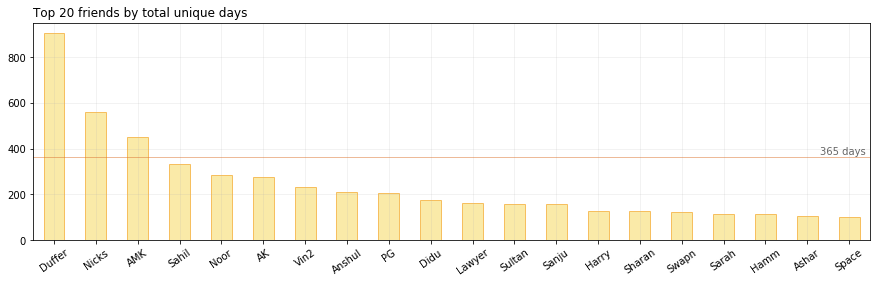

In [195]:
n = 20
temp = top_n.loc[:, ["PERSON", "UNIQ_DAYS"]].sort_values(by="UNIQ_DAYS", ascending=False).head(n)

fig, ax = plt.subplots(figsize=(15, 4))
temp.plot(x="PERSON", y="UNIQ_DAYS", kind="bar", ax=ax, color="#f7dc6f", edgecolor='#f39c12', alpha=0.6)
ax.axhline(y=365, color="#dc7633", linewidth=0.5)
ax.text(n-1.7, 365+10, "365 days", alpha=0.6)

ax.grid(b=True, which='major', linestyle='-', alpha=0.2)
ax.set_title(f"Top {n} friends by total unique days", loc="left")
ax.set_xlabel("")
plt.sca(ax)
plt.xticks(rotation=35)
ax.legend().set_visible(False)
_ = fig


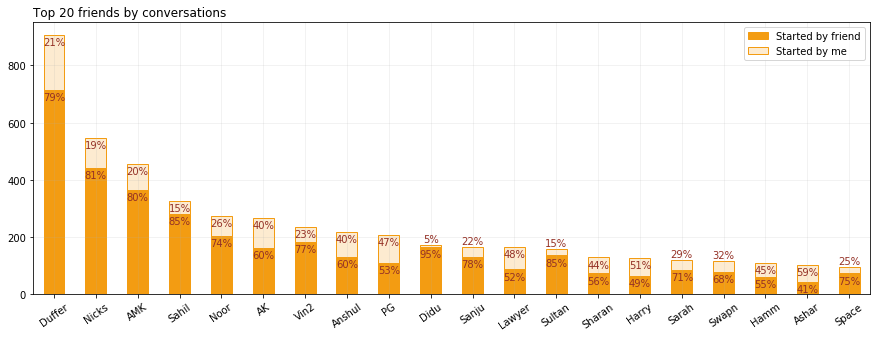

In [194]:
n = 20
conv_starts = non_group_data.groupby("PERSON").STARTS.sum()
conv_starts_me = non_group_data[non_group_data.FROM=="Shivam Rana"].groupby("PERSON").STARTS.sum()
conv_starts_others = non_group_data[non_group_data.FROM!="Shivam Rana"].groupby("PERSON").STARTS.sum()

temp = pd.concat([conv_starts, conv_starts_me, conv_starts_others], axis=1)
temp.columns = ["CONVERSATIONS", "CONV_STRT_ME", "CONV_STRT_FRND"]
temp = temp.sort_values("CONVERSATIONS", ascending=False).head(n)

fig, ax = plt.subplots(figsize=(15, 5))
temp[["CONV_STRT_FRND", "CONV_STRT_ME"]].plot(kind="bar", ax=ax, color=["#f39c12", "#fdebd0"], edgecolor='#f39c12', label="Started by me", stacked=True)

for i, (j, k) in enumerate(zip(temp.CONV_STRT_FRND, temp.CONVERSATIONS)):
    ax.text(i, j-25, f"{round(j*100/k)}%", ha="center", va="center", color="#943126")

for i, (j, k) in enumerate(zip(temp.CONV_STRT_ME, temp.CONVERSATIONS)):
    if i in [9, 10, 12, 15, 16, 19]:
        ax.text(i, k+20, f"{round(j*100/k)}%", ha="center", va="center", color="#943126")
    else:
        ax.text(i, k-25, f"{round(j*100/k)}%", ha="center", va="center", color="#943126")

ax.grid(b=True, which='major', linestyle='-', alpha=0.2)
ax.set_title(f"Top {n} friends by conversations", loc="left")
ax.set_xlabel("")
plt.sca(ax)
plt.xticks(rotation=35)
ax.legend(["Started by friend", "Started by me"])

_ = fig



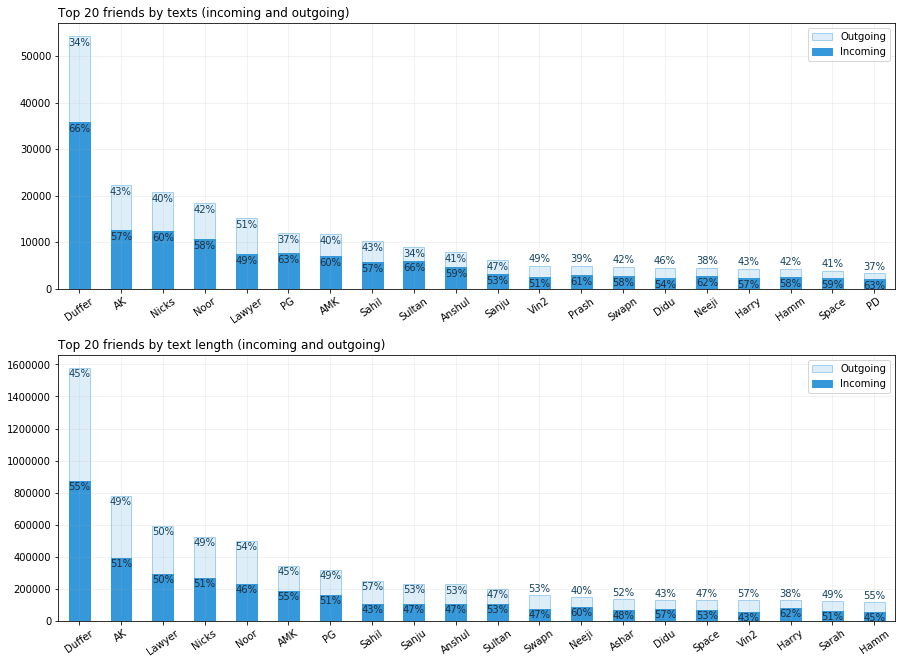

In [215]:
n = 20
temp = top_n.loc[:, ["PERSON", "TCNT", "TCNT_FRIEND"]].sort_values(by="TCNT", ascending=False).head(n)

fig, (ax, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 11))
temp.plot(x="PERSON", y="TCNT", kind="bar", ax=ax, color="#aed6f1", edgecolor='#3498db', label="Outgoing", alpha=0.4)
temp.plot(x="PERSON", y="TCNT_FRIEND", kind="bar", ax=ax, color="#3498db", edgecolor='#3498db', label="Incoming")

for i, (j, k) in enumerate(zip(temp.TCNT_FRIEND, temp.TCNT)):
    ax.text(i, j-1500, f"{round(j*100/k)}%", ha="center", va="center", color="#212f3d")

for i, (j, k) in enumerate(zip(temp.TCNT_FRIEND, temp.TCNT)):
    if i in list(range(11,n)):
        ax.text(i, k+1500, f"{round((k-j)*100/k)}%", ha="center", va="center", color="#154360")
    else:
        ax.text(i, k-1500, f"{round((k-j)*100/k)}%", ha="center", va="center", color="#154360")

ax.grid(b=True, which='major', linestyle='-', alpha=0.2)
ax.set_title(f"Top {n} friends by texts (incoming and outgoing)", loc="left")
plt.sca(ax)
plt.xticks(rotation=35)#3498db
ax.set_xlabel("")
ax.legend()


n = 20
temp = top_n.loc[:, ["PERSON", "TLEN", "TLEN_FRIEND"]].sort_values(by="TLEN", ascending=False).head(n)
    
temp.plot(x="PERSON", y="TLEN", kind="bar", ax=ax2, color="#aed6f1", edgecolor='#3498db', label="Outgoing", alpha=0.4)
temp.plot(x="PERSON", y="TLEN_FRIEND", kind="bar", ax=ax2, color="#3498db", edgecolor='#3498db', label="Incoming")

for i, (j, k) in enumerate(zip(temp.TLEN_FRIEND, temp.TLEN)):
    ax2.text(i, j-37000, f"{round(j*100/k)}%", ha="center", va="center", color="#212f3d")

for i, (j, k) in enumerate(zip(temp.TLEN_FRIEND, temp.TLEN)):
    if i in list(range(11, n)):
        ax2.text(i, k+37000, f"{round((k-j)*100/k)}%", ha="center", va="center", color="#154360")
    else:
        ax2.text(i, k-37000, f"{round((k-j)*100/k)}%", ha="center", va="center", color="#154360")

ax2.grid(b=True, which='major', linestyle='-', alpha=0.2)
ax2.set_title(f"Top {n} friends by text length (incoming and outgoing)", loc="left")
ax2.set_xlabel("")
plt.sca(ax2)
plt.xticks(rotation=35)
ax2.legend()

fig.subplots_adjust(hspace=0.25)

_ = fig



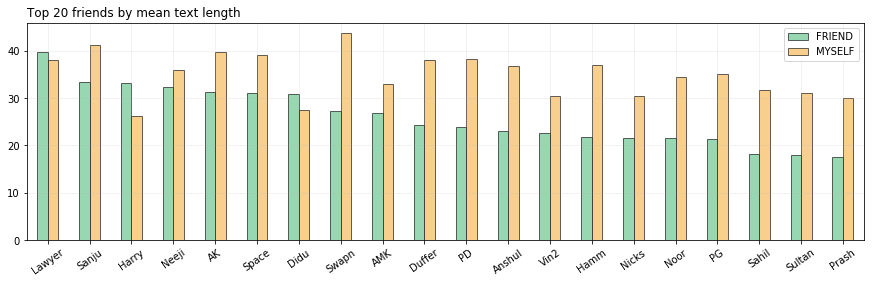

In [217]:
n = 20
top_n_friends = top_n.sort_values(by="TCNT", ascending=False).PERSON.values[:n]
temp = top_n.loc[:, ["PERSON", "MLEN_FRIEND", "MLEN_ME"]]
cond = temp.PERSON.apply(lambda x: True if x in top_n_friends else False)
temp = temp.loc[cond].head(n).sort_values(by="MLEN_FRIEND", ascending=False)
temp.index = temp.PERSON

fig, ax = plt.subplots(figsize=(15, 4))
temp.loc[:,["MLEN_FRIEND", "MLEN_ME"]].plot.bar(ax=ax, color=["#52be80", "#f5b041"], alpha=0.6, edgecolor=[])

ax.grid(b=True, which='major', linestyle='-', alpha=0.2)
ax.set_title(f"Top {n} friends by mean text length", loc="left")
ax.set_xlabel("")
plt.sca(ax)
plt.xticks(rotation=35)
ax.legend(["FRIEND", "MYSELF"])

_ = fig


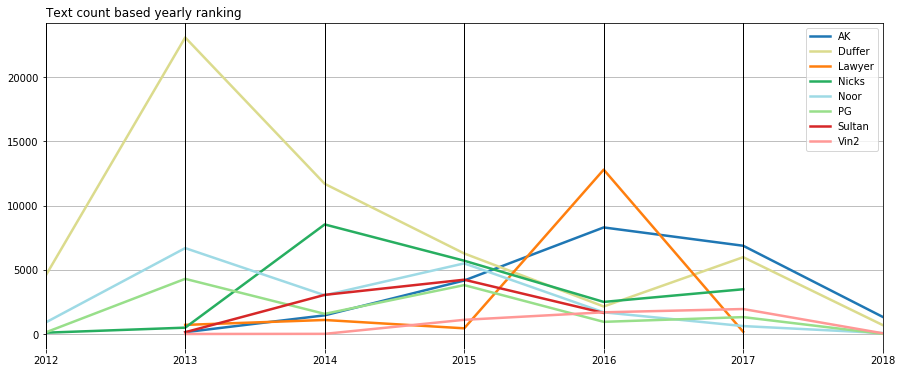

In [245]:
yearly_parallel = non_group_data.pivot_table(index="PERSON", columns="YEAR", values="TEXT", aggfunc="count").reset_index(level=0)

friends = ['Duffer', 'AK', 'Nicks', 'Noor', 'Lawyer',
           'PG', 'Sultan', 'Vin2']
temp = yearly_parallel.loc[yearly_parallel.PERSON.isin(friends), ["PERSON"] + list(range(2012, 2019))]

color_sequence = [
    '#1f77b4', '#dbdb8d', '#ff7f0e', '#27ae60', '#9edae5',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#ffbb78', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#aec7e8', '#2ca02c', '#e377c2'
]

fig, ax = plt.subplots(figsize=(15, 6))
parallel_coordinates(temp, "PERSON", ax=ax, lw=2.5, color=color_sequence[:len(friends)])

ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.set_title("Text count based yearly ranking", loc="left")

_ = ax

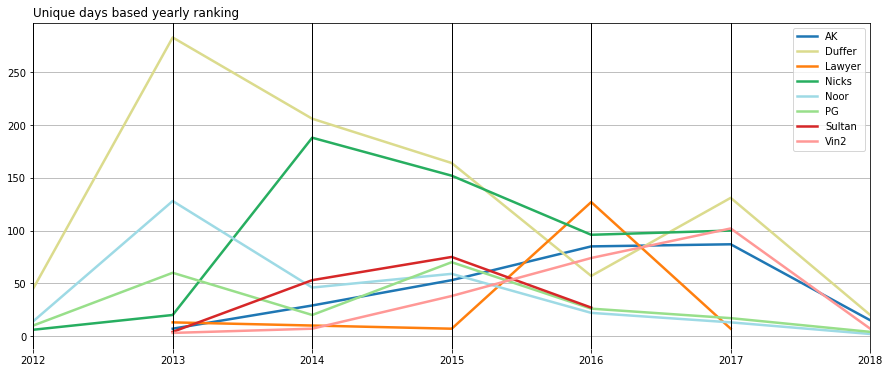

In [246]:
yearly_parallel = non_group_data.pivot_table(index="PERSON", columns="YEAR", values="DATE", aggfunc="nunique").reset_index(level=0)

friends = ['Duffer', 'AK', 'Nicks', 'Noor', 'Lawyer',
           'PG', 'Sultan', 'Vin2']
temp = yearly_parallel.loc[yearly_parallel.PERSON.isin(friends), ["PERSON"] + list(range(2012, 2019))]

fig, ax = plt.subplots(figsize=(15, 6))
parallel_coordinates(temp, "PERSON", ax=ax, lw=2.5, color=color_sequence[:len(friends)])

ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.set_title("Unique days based yearly ranking", loc="left")
# ax.legend().set_visible(False)

_ = ax

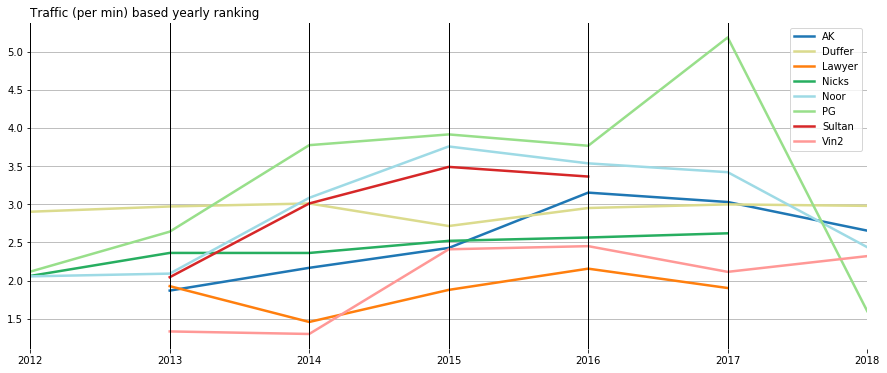

In [247]:
yearly_parallel1 = non_group_data.pivot_table(index="PERSON", columns="YEAR", values="TEXT", aggfunc="count")
yearly_parallel2 = non_group_data.pivot_table(index="PERSON", columns="YEAR", values="DATEHRMIN", aggfunc="nunique")
yearly_parallel = (yearly_parallel1 / yearly_parallel2).reset_index(level=0)

friends = ['Duffer', 'AK', 'Nicks', 'Noor', 'Lawyer',
           'PG', 'Sultan', 'Vin2']
temp = yearly_parallel.loc[yearly_parallel.PERSON.isin(friends), ["PERSON"] + list(range(2012, 2019))]


fig, ax = plt.subplots(figsize=(15, 6))
parallel_coordinates(temp, "PERSON", ax=ax, lw=2.5, color=color_sequence[:len(friends)])

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title("Traffic (per min) based yearly ranking", loc="left")
# ax.legend().set_visible(False)

_ = ax

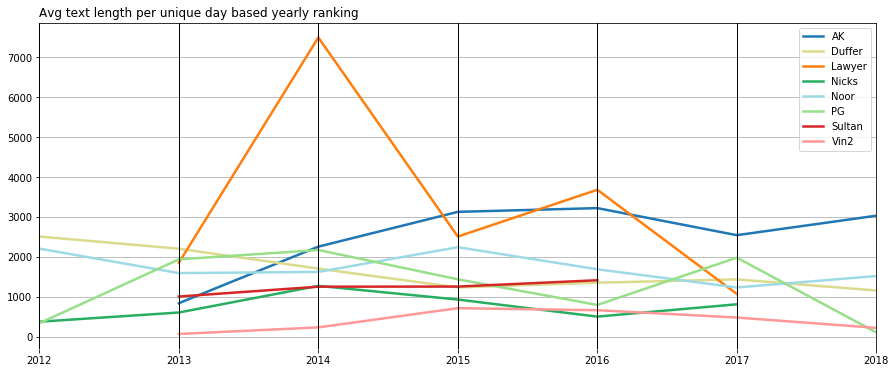

In [248]:
yearly_parallel1 = non_group_data.pivot_table(index="PERSON", columns="YEAR", values="TLEN", aggfunc="sum")
yearly_parallel2 = non_group_data.pivot_table(index="PERSON", columns="YEAR", values="DATE", aggfunc="nunique")
yearly_parallel = (yearly_parallel1 / yearly_parallel2).reset_index(level=0)

friends = ['Duffer', 'AK', 'Nicks', 'Noor', 'Lawyer',
           'PG', 'Sultan', 'Vin2']
temp = yearly_parallel.loc[yearly_parallel.PERSON.isin(friends), ["PERSON"] + list(range(2012, 2019))]


fig, ax = plt.subplots(figsize=(15, 6))
parallel_coordinates(temp, "PERSON", ax=ax, lw=2.5, color=color_sequence[:len(friends)])

ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.set_title("Avg text length per unique day based yearly ranking", loc="left")
# ax.legend().set_visible(False)

_ = ax


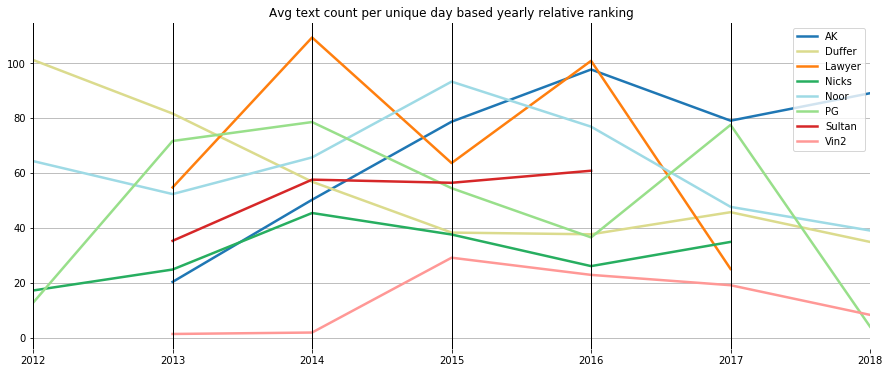

In [238]:
yearly_parallel1 = non_group_data.pivot_table(index="PERSON", columns="YEAR", values="TEXT", aggfunc="count")
yearly_parallel2 = non_group_data.pivot_table(index="PERSON", columns="YEAR", values="DATE", aggfunc="nunique")
yearly_parallel = (yearly_parallel1 / yearly_parallel2).reset_index(level=0)

friends = ['Duffer', 'AK', 'Nicks', 'Noor', 'Lawyer',
           'PG', 'Sultan', 'Vin2']
temp = yearly_parallel.loc[yearly_parallel.PERSON.isin(friends), ["PERSON"] + list(range(2012, 2019))]


fig, ax = plt.subplots(figsize=(15, 6))
parallel_coordinates(temp, "PERSON", ax=ax, lw=2.5, color=color_sequence[:len(friends)])

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title("Avg text count per unique day based yearly relative ranking")
# ax.legend().set_visible(False)

_ = ax


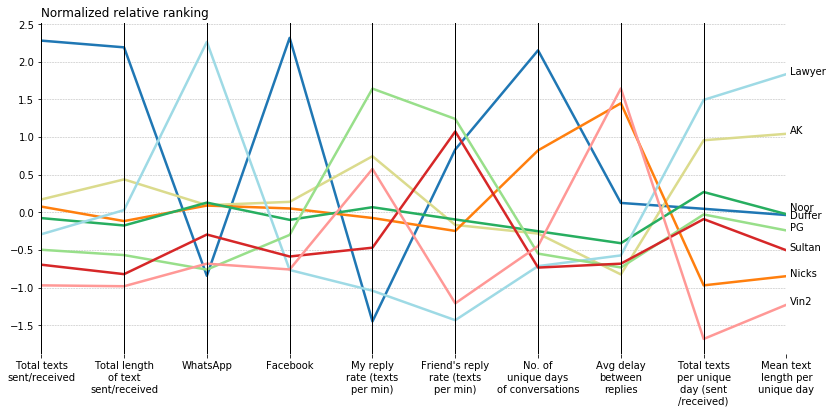

In [298]:
cols = [
    'PERSON',
    'TCNT', 
#     'TCNT_FRIEND',
    'TLEN', 
#     'TLEN_FRIEND',
    "WP", "FB",
    "MYRRT", "FRNDRRT",
    'UNIQ_DAYS',    
#     'MLEN_FRIEND', 
#     'MLEN_ME',
    "TDIFF",
    "TCNTDAY", 
    'MLENDAY',
#     "TCNTDAY_FRIEND", 
#     'MLENDAY_FRIEND',
#     "TCNTDAY_ME", 
#     'MLENDAY_ME',
]
friends = ['Duffer', 'AK', 'Nicks', 'Noor', 'Lawyer',
           'PG', 'Sultan', 'Vin2']
temp = top_n.loc[top_n.PERSON.isin(friends), cols].sort_values(by="TCNT", ascending=False)
temp.loc[:, temp.columns[1:]] = (temp.loc[:, temp.columns[1:]]-temp.loc[:, temp.columns[1:]].mean())/temp.loc[:, temp.columns[1:]].std()

color_sequence = [
    '#1f77b4', '#dbdb8d', '#ff7f0e', '#27ae60', '#9edae5',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#ffbb78', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#aec7e8', '#2ca02c', '#e377c2'
]

fig, ax = plt.subplots(figsize=(15, 5))
parallel_coordinates(temp, "PERSON", ax=ax, lw=2.5, color=color_sequence[:len(friends)])

ax.set_xticklabels(["Total texts\nsent/received", 
#                     "Total texts\nsentby\nfriend",
                    "Total length\nof text\nsent/received", 
#                     "Total length\nof text\nsent by friend",
                    "WhatsApp", "Facebook",
                    "My reply\nrate (texts\nper min)", "Friend's reply\nrate (texts\nper min)", 
                    "No. of\nunique days\nof conversations",
#                     "Mean length of\ntext sent\nby friend", 
#                     "Mean length\nof text\nI sent",
                    "Avg delay\nbetween\nreplies",
                    "Total texts\nper unique\nday (sent\n/received)",
                    'Mean text\nlength per\nunique day',
#                     "Total texts\nper unique\ndays sent\nby friend", 
#                     'Mean text\nlength of\nfriend per\nunique day',
#                     "Total texts\nper unique\ndays sent\nby me", 
#                     'Mean text\nlength I\nsent per\nunique day',
                    ])

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title("Normalized relative ranking", loc="left")
ax.legend().set_visible(False)

for pos, disptext in zip(temp.MLENDAY, temp.PERSON):
    if disptext == "Duffer":
        pos -= 0.05
    elif disptext == "Noor":
        pos += 0.05
    ax.text(9+0.04, pos, disptext)

fig.subplots_adjust(left=.06, right=.75, bottom=.02, top=.94)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

_ = ax


In [241]:
n=20
all_dates = pd.DataFrame(index=pd.date_range("2012-01-01", non_group_data.DATE.max()))

daily_stacked_count = non_group_data.pivot_table(index="DATE", columns="PERSON", values="TEXT", aggfunc="count")
daily_stacked_count = all_dates.join(daily_stacked_count)
top_n_friends = top_n.sort_values(by="TCNT", ascending=False).PERSON.values[:n]
daily_stacked_count = daily_stacked_count[top_n_friends]

daily_stacked_tlen = non_group_data.pivot_table(index="DATE", columns="PERSON", values="TLEN", aggfunc="sum")
daily_stacked_tlen = all_dates.join(daily_stacked_tlen)
top_n_friends = top_n.sort_values(by="TCNT", ascending=False).PERSON.values[:n]
daily_stacked_tlen = daily_stacked_tlen[top_n_friends]


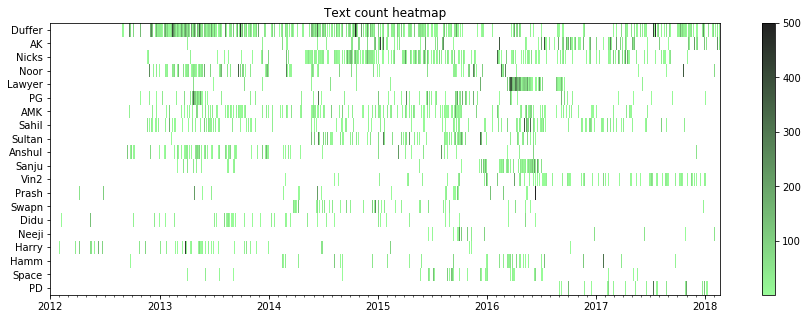

In [244]:
temp = daily_stacked_count.copy(deep=True)

# https://stackoverflow.com/a/45349235/2650427
dnum = mdates.date2num(temp.index.to_pydatetime())
start = dnum[0] - (dnum[1]-dnum[0])/2.
stop = dnum[-1] + (dnum[1]-dnum[0])/2.
extent = [start, stop, -0.5, len(temp.columns)-0.5]

fig, ax = plt.subplots(figsize=(15, 5))
im = ax.imshow(
    temp.T,
    vmax=500,
    aspect="auto", extent=extent, 
    cmap=sns.dark_palette("palegreen", as_cmap=True, reverse=True)
)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_yticks(range(len(temp.columns)))
ax.set_yticklabels(temp.columns.values[::-1])
ax.set_title("Text count heatmap")
fig.colorbar(im)

_ = ax

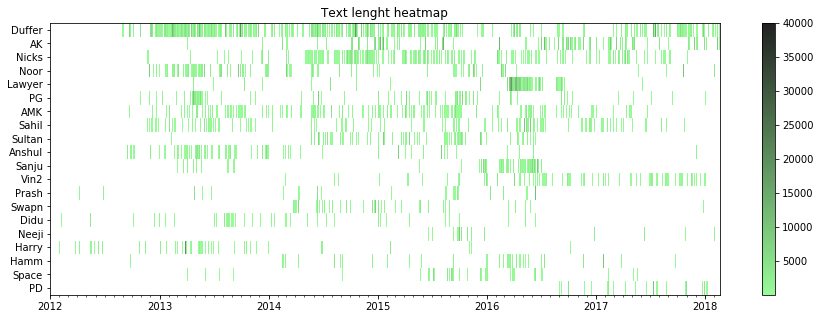

In [250]:
temp = daily_stacked_tlen.copy(deep=True)

# https://stackoverflow.com/a/45349235/2650427
dnum = mdates.date2num(temp.index.to_pydatetime())
start = dnum[0] - (dnum[1]-dnum[0])/2.
stop = dnum[-1] + (dnum[1]-dnum[0])/2.
extent = [start, stop, -0.5, len(temp.columns)-0.5]

fig, ax = plt.subplots(figsize=(15, 5))
im = ax.imshow(
    temp.T,
    vmax=40000,
    aspect="auto", extent=extent, 
    cmap=sns.dark_palette("palegreen", as_cmap=True, reverse=True)
)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_yticks(range(len(temp.columns)))
ax.set_yticklabels(temp.columns.values[::-1])
ax.set_title("Text lenght heatmap")
fig.colorbar(im)

_ = ax


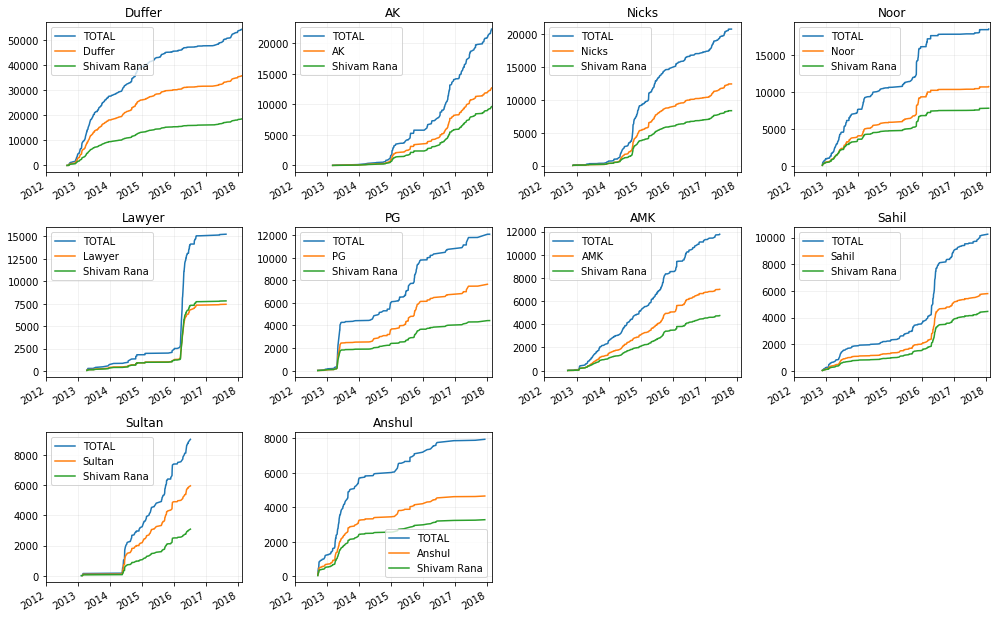

In [262]:
# Getting all the friends from the above top n lists
# top_n_friends = list(set(pd.np.concatenate((top_n_total_days.PERSON.values, pd.np.array(top_n_total.index), top_n_total_len.PERSON.values))))
n = 10
top_n_friends = top_n.sort_values(by="TCNT", ascending=False).PERSON.values[:n]
len(top_n_friends)

nrows = 5
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14), sharex=True, sharey=True)

for i, frnd in enumerate(top_n_friends):
    frnd_df = non_group_data[non_group_data.PERSON == frnd]
    frnd_df_cum = frnd_df.groupby("DATE").agg({"TEXT": "count"}).cumsum(axis=0)
    frnd_df_cum_sent = frnd_df[frnd_df.FROM == "Shivam Rana"].groupby("DATE").agg({"TEXT": "count"}).cumsum(axis=0)
    frnd_df_cum_recv = frnd_df[frnd_df.FROM != "Shivam Rana"].groupby("DATE").agg({"TEXT": "count"}).cumsum(axis=0)
    
    ax = plt.subplot(nrows, ncols, i+1)
    frnd_df_cum.plot(ax=ax)
    frnd_df_cum_recv.plot(ax=ax)
    frnd_df_cum_sent.plot(ax=ax)
    
    plt.grid(b=True, which='major', linestyle='-', alpha=0.2)
    plt.xlim(datetime.datetime(2012, 1, 1), non_group_data.DATE.max())
    plt.title(frnd)
    plt.legend(["TOTAL", frnd, "Shivam Rana"])
    plt.xlabel("")
    
while i+1 < nrows*ncols:
    fig.delaxes(plt.subplot(nrows, ncols, i+2))
    i += 1

# fig.suptitle("Cumulative message count")
fig.tight_layout()



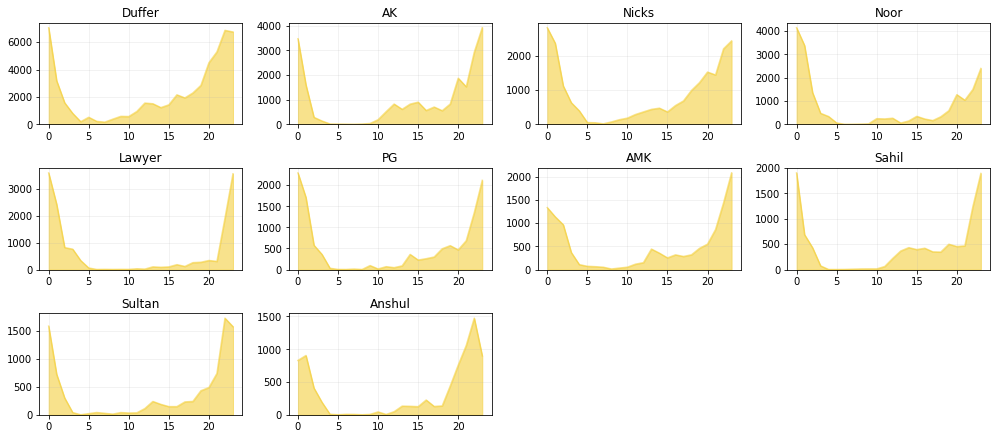

In [258]:
# Getting all the friends from the above top n lists
# top_n_friends = list(set(pd.np.concatenate((top_n_total_days.PERSON.values, pd.np.array(top_n_total.index), top_n_total_len.PERSON.values))))
n = 10
top_n_friends = top_n.sort_values(by="TCNT", ascending=False).PERSON.values[:n]
len(top_n_friends)

nrows = 5
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 10), sharex=True, sharey=True)

for i, frnd in enumerate(top_n_friends):
    frnd_df = non_group_data[non_group_data.PERSON == frnd]
    frnd_hour_wise = frnd_df.groupby("HOUR", as_index=False).agg({"TEXT": "count"}).sort_values(by="HOUR")
    
    ax = plt.subplot(nrows, ncols, i+1)    
    frnd_hour_wise.plot(x="HOUR", y="TEXT", kind="area", ax=ax, color="#f4d03f", alpha=0.6)
    plt.grid(b=True, which='major', linestyle='-', alpha=0.2)
    plt.title(frnd)
    ax.legend().set_visible(False)
    plt.xlabel("")
    
while i+1 < nrows*ncols:
    fig.delaxes(plt.subplot(nrows, ncols, i+2))
    i += 1

# fig.suptitle("Cumulative message count")
fig.tight_layout()



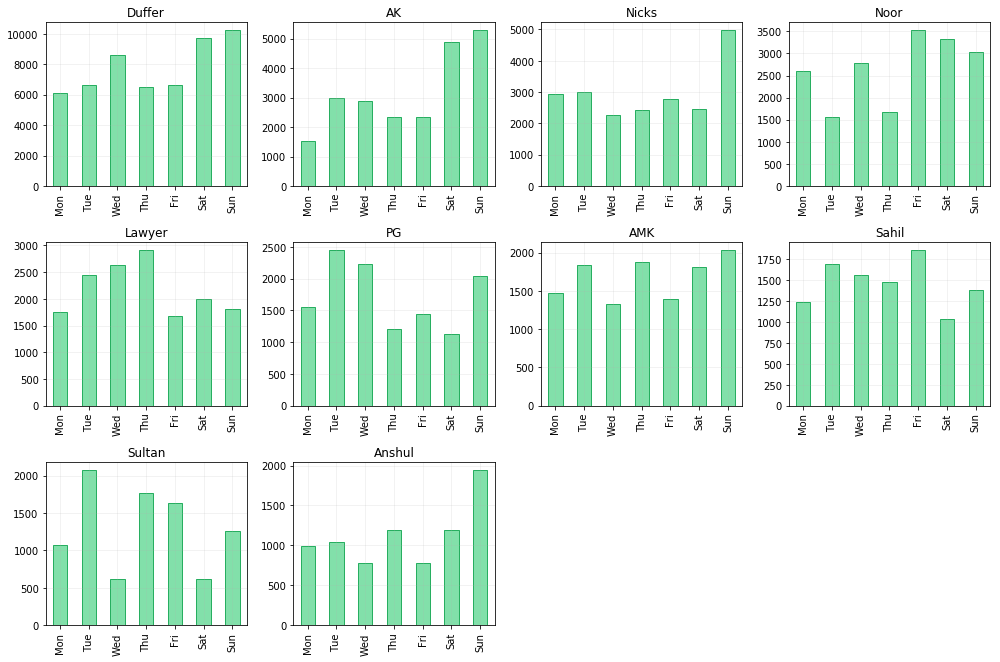

In [256]:
# Getting all the friends from the above top n lists
# top_n_friends = list(set(pd.np.concatenate((top_n_total_days.PERSON.values, pd.np.array(top_n_total.index), top_n_total_len.PERSON.values))))
n = 10
top_n_friends = top_n.sort_values(by="TCNT", ascending=False).PERSON.values[:n]

nrows = 5
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 15), sharex=True, sharey=True)

day_dict = pd.DataFrame({"ORDER": [1,2,3,4,5,6,7]}, index=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])

for i, frnd in enumerate(top_n_friends):
    frnd_df = non_group_data[non_group_data.PERSON == frnd]
    frnd_weekday_wise = frnd_df.groupby("DAY").agg({"TEXT": "count"}).join(day_dict).sort_values(by="ORDER")
    del frnd_weekday_wise["ORDER"]
    
    ax = plt.subplot(nrows, ncols, i+1)
    frnd_weekday_wise.plot(kind="bar", ax=ax, color="#82e0aa", edgecolor="#27ae60")
    plt.grid(b=True, which='major', linestyle='-', alpha=0.2)
    plt.title(frnd)
    ax.legend().set_visible(False)
    plt.xlabel("")
    
while i+1 < nrows*ncols:
    fig.delaxes(plt.subplot(nrows, ncols, i+2))
    i += 1

# fig.suptitle("Cumulative message count")
fig.tight_layout()



## Poisson Distribution

Conditions for Poisson Distribution:

- An event can occur any number of times during a time period.
- Events occur independently. In other words, if an event occurs, it does not affect the probability of another event occurring in the same time period.
- The rate of occurrence is constant; that is, the rate does not change based on time.
- The probability of an event occurring is proportional to the length of the time period. For example, it should be twice as likely for an event to occur in a 2 hour time period than it is for an event to occur in a 1 hour period. 
    

In [60]:
def poisson(k, lam):
    """
    Returns the probability of having k ocurrences assuming
    a Poisson distribution behind the occurence.
    """
    return ((lam**k)*np.exp(-lam))/factorial(k)


2.545049063336307 5.286010729407768
Power_divergenceResult(statistic=412.17635655147132, pvalue=3.4513200202204342e-83)


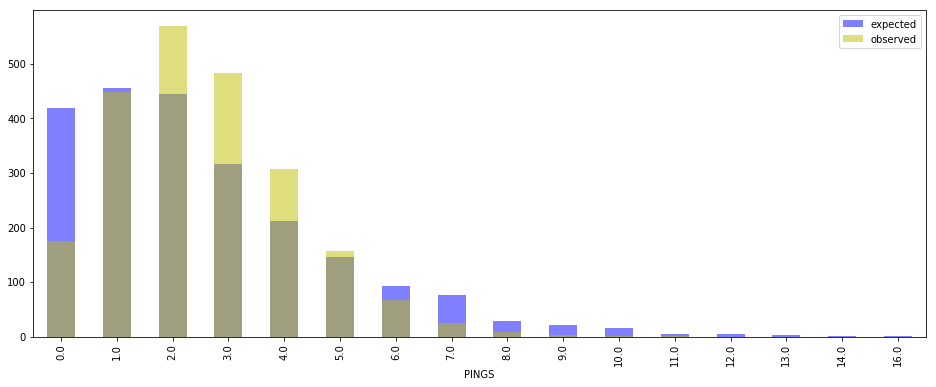

In [336]:
# 10 hours
time_threshold = 15*60*60
cond1 = data.TDIFF > time_threshold
cond2 = data.TDIFF.isnull()

# Getting new pings
data.loc[:, "PINGS"] = (cond1 | cond2).astype(int)

# Filtering out the group chats
cond3 = (data.GRPFLG == 0)

# Preparing the ping data
date_pings = data.loc[cond3, ["DATE", "PINGS"]].groupby("DATE", as_index=False)["PINGS"].sum()
temp = pd.DataFrame(dict(DATE = pd.date_range("2012-01-01", "2018-02-19")))
temp = temp.merge(date_pings, on="DATE", how="left")
temp = temp.replace(np.nan, 0)
# print(temp.head())

# Calculating Poisson values
l = temp.PINGS.mean()
temp["POISSON"] = temp.PINGS.apply(poisson, args=(l, ))
print(l, temp.PINGS.var())

# Poisson frequency dataframe
poisson_df = pd.DataFrame({"PINGS": temp.PINGS, "POISSON": temp.POISSON}).drop_duplicates().sort_values(by="PINGS")

dates = temp.shape[0]
poisson_df["observed"] = round(poisson_df.POISSON * dates, 3)

pings_date = temp.groupby("PINGS", as_index=False)["DATE"].count().rename(columns={"DATE": "expected"})
poisson_df = poisson_df.merge(pings_date, on="PINGS")

# chi square test
dof = poisson_df.shape[0]-1-1
# dof = (poisson_df.shape[0]-1)*(poisson_df.shape[1]-1)
print(chisquare(poisson_df.observed, f_exp=poisson_df.expected, ddof=6))

# Plotting
fig, ax = plt.subplots(figsize=(16, 6))
poisson_df.plot(x="PINGS", y="expected", kind="bar", ax=ax, color='b', alpha=0.5)
poisson_df.plot(x="PINGS", y="observed", kind="bar", ax=ax, color='y', alpha=0.5)
_ = ax

In [337]:
poisson_df

,PINGS,POISSON,observed,expected
0,0.0,7.846920e-02,175.928,419
1,1.0,1.997080e-01,447.745,456
2,2.0,2.541333e-01,569.767,444
3,3.0,2.155939e-01,483.362,317
4,4.0,1.371743e-01,307.545,212
5,5.0,6.982305e-02,156.543,145
6,6.0,2.961718e-02,66.402,93
7,7.0,1.076817e-02,24.142,77
8,8.0,3.425689e-03,7.680,28
9,9.0,9.687275e-04,2.172,22


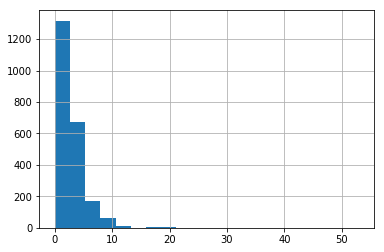

In [148]:
temp.PINGS.hist(bins=20)

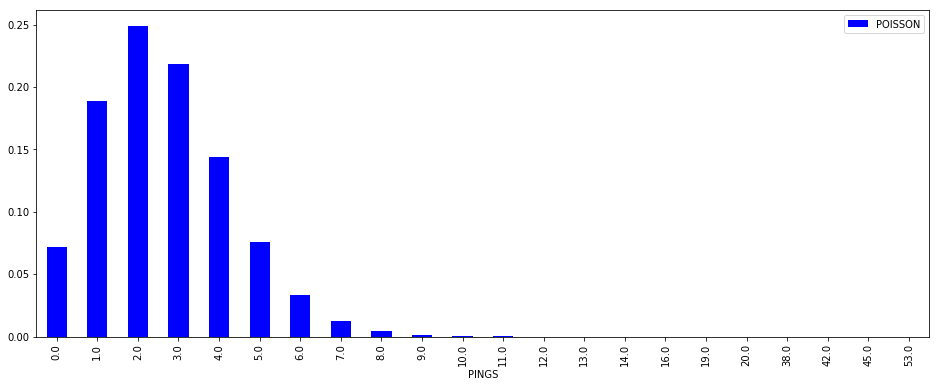

In [149]:
fig, ax = plt.subplots(figsize=(16, 6))
poisson_df.plot(x="PINGS", y="POISSON", kind="bar", ax=ax, color="b")